In [1]:
!pip install wandb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Dense,MaxPool2D,Flatten,Conv2D
import os
from tensorflow.keras import layers
from wandb.keras import WandbCallback
import wandb
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -qq utkface-new.zip

replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
width=height=224
batch_size=32

In [7]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
images = [] # X
ages = [] # Y

for image_name in os.listdir('crop_part1')[0: 9000]:
    parts = image_name.split('_')
    ages.append(int(parts[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [9]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

df = pd.concat([images, ages], axis=1)
df.head()

,Images,Ages
0,"[[[3, 1, 6], [3, 1, 6], [2, 2, 4], [1, 2, 4], ...",1
1,"[[[250, 250, 250], [250, 250, 250], [250, 250,...",72
2,"[[[95, 77, 63], [100, 82, 68], [108, 89, 75], ...",47
3,"[[[74, 107, 64], [74, 107, 62], [76, 109, 62],...",7
4,"[[[116, 119, 112], [115, 118, 111], [112, 111,...",43


1


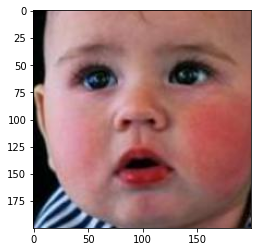

In [10]:
print(df['Ages'][0])
plt.imshow(df['Images'][0])

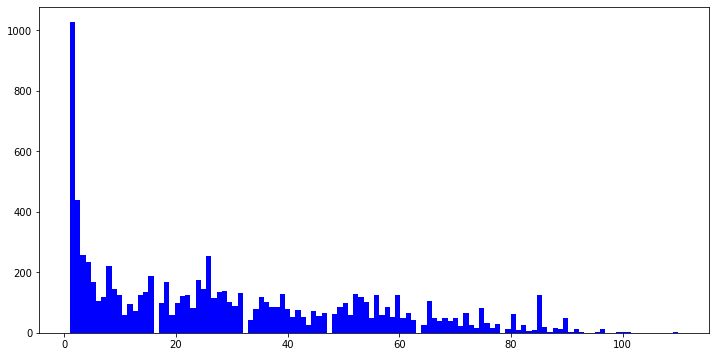

In [11]:
plt.figure(figsize=(12, 6))
plt.hist(df['Ages'], bins=116, color='blue')
plt.show()

In [12]:
under_4 = []
for i in range(len(df)):
  if df['Ages'].iloc[i] <= 4:
    under_4.append(df.iloc[i])
under_4 = pd.DataFrame(under_4)
under_4 = under_4.sample(frac=0.3)
up_4 = df[df['Ages'] > 4]
df = pd.concat([under_4, up_4])

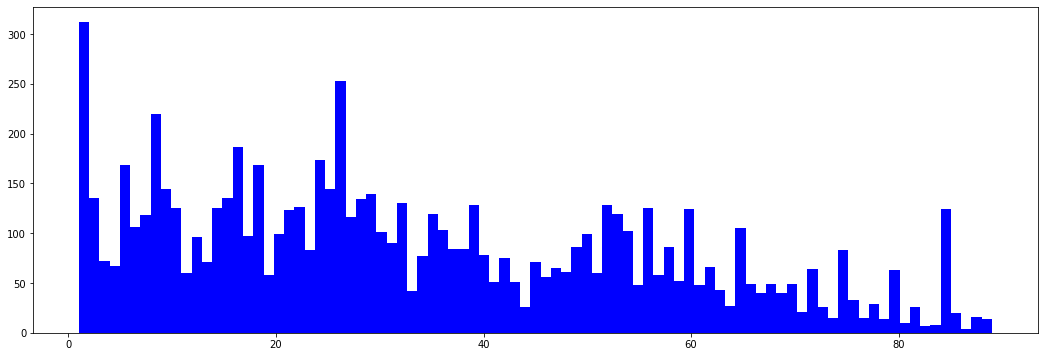

In [13]:
df = df[df['Ages'] < 90]
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=89, color='blue')
plt.show()

In [14]:
X = []
Y =[]
for i in range(len(df)):
  df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))
  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])
X= np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
from sklearn.model_selection import train_test_split
X.shape
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

In [16]:
x_train.shape

(6035, 224, 224, 3)

In [17]:
data_generator=ImageDataGenerator(
rescale=1/255,
horizontal_flip=True,
)


In [18]:
data_generator = ImageDataGenerator(rescale=1/.255,
                                    horizontal_flip=True)

train_data = data_generator.flow(x_train,
                                 y_train,
                                 batch_size=batch_size)

val_data = data_generator.flow(x_val,
                                 y_val,
                                 batch_size=batch_size)

In [19]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
    )

In [20]:
model = tf.keras.Sequential([
        base_model,
        Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='linear'),              
])

In [21]:
wandb.init(project="Age_pridiction")

wandb: Currently logged in as: zeinabmostafavi (use `wandb login --relogin` to force relogin)


In [24]:
config = wandb.config
config.learning_rate = 0.001


model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate))



In [25]:
model.fit(train_data,
          validation_data=val_data,
          epochs=10,
          shuffle=True)

Epoch 1/10
189/189 [==============================] - 142s 713ms/step - loss: 1285.5251 - val_loss: 1899.4254
Epoch 2/10
189/189 [==============================] - 130s 689ms/step - loss: 885.5955 - val_loss: 854.3759
Epoch 3/10
189/189 [==============================] - 130s 689ms/step - loss: 527.8081 - val_loss: 957.7811
Epoch 4/10
189/189 [==============================] - 130s 689ms/step - loss: 248.6041 - val_loss: 216.7640
Epoch 5/10
189/189 [==============================] - 130s 689ms/step - loss: 125.1273 - val_loss: 191.3732
Epoch 6/10
189/189 [==============================] - 130s 689ms/step - loss: 86.4473 - val_loss: 142.4625
Epoch 7/10
189/189 [==============================] - 130s 689ms/step - loss: 68.7895 - val_loss: 98.7934
Epoch 8/10
189/189 [==============================] - 130s 689ms/step - loss: 68.7043 - val_loss: 118.2722
Epoch 9/10
189/189 [==============================] - 130s 688ms/step - loss: 66.7373 - val_loss: 152.1966
Epoch 10/10
189/189 [==========

In [26]:
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
